# ProvedArea.py Demo
---


## Proved Area: Single Realization

To begin, we first instantiate a `ProvedArea()` object with the `realizations` parameter set to `1`. Additionally, we need to supply the file paths for the required well header and forecast parameter data sets.

Currently, the `ProvedArea()` object is set-up to run all realizations of the SPEE Monograph 3 workflow upon initialization. Once all realizations have completed, we can then utilize the various package methods to visualize and export our data set.

In [48]:
from ProvedArea import ProvedArea

headers = 'ComboCurve Header Example.csv'
forecast_parameters = 'ComboCurve Forecast Parameter Example.csv'

single_realization = ProvedArea(realizations = 1, header_path = headers, forecast_parameters_path = forecast_parameters)

Generating realizations...
Realization Number: 1

All realizations completed successfully.
Proved Radii Distance: 3.0 miles


### Review realization outputs

Using the `plot_comparisons()` method we can view the results of our realization. The left chart shows the Average EUR/PLL of the various well groupings and is used to determine what radii level is considered proved. According to SPEE Monograph 3, the <i>proved</i> radii group is that which preceeds the radii group whose Average EUR/PLL dips below 90% of the analog well set's Average EUR/PLL. The chart on the right shows the corresponding well count for each of the well groupings. In this case, the proved radii group would be <b>r3</b> since r4 dips below the 90% threshold.

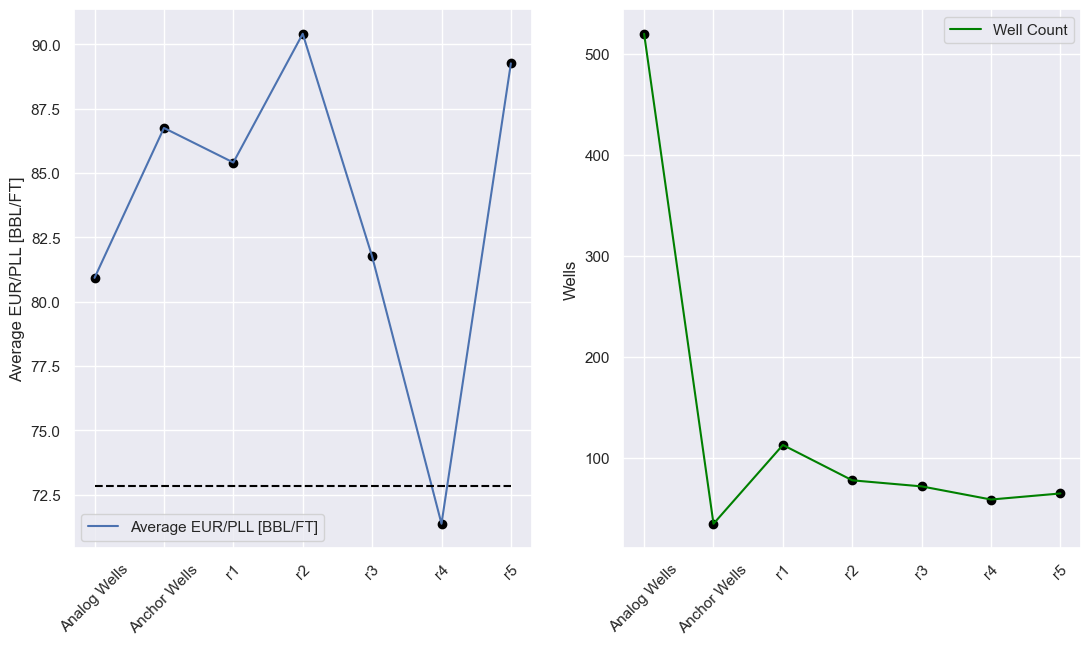

In [49]:
single_realization.plot_comparisons()

### Visualize Analog and Anchor Wells

Using the `plot_wells()` method we can quickly identify both the analog and anchor wells in addition to the wells that were encompassed by the expanding radii layers. As defined in the legend, the wells shown in black are the analog wells, while the anchor wells are the center points of the expanding grey concentric radii. The wells that lie within the concentric expanding radii are color-coded according to which layer they fall into. 

Note: Currently, ProvedArea.py uses a well's surface hole coordinates to define its location.

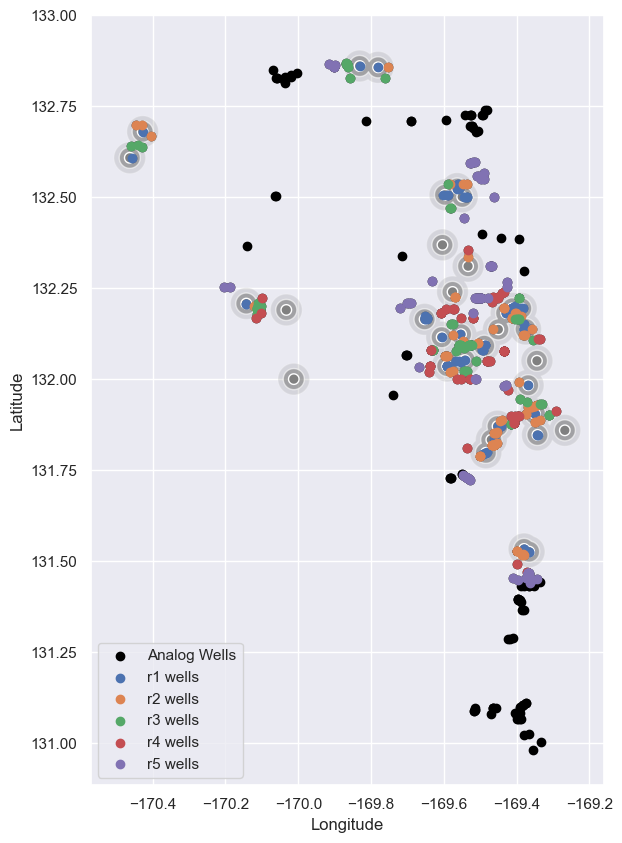

In [50]:
single_realization.plot_wells()

### Define the Proved Radii and Proved Area

Using the `plot_proved_areas()` method, we can visualize the proved radii bubbles along with the final proved area boundaries created by our alphashape. The proved area geometries represent the portions of the resource play that can be considered "statistically proven." 

It is important to note here that due to the random nature of how the anchor points are selected, the proved area shown below is non-unique and is highly dependant upon which random points were originally selected as our anchor set.

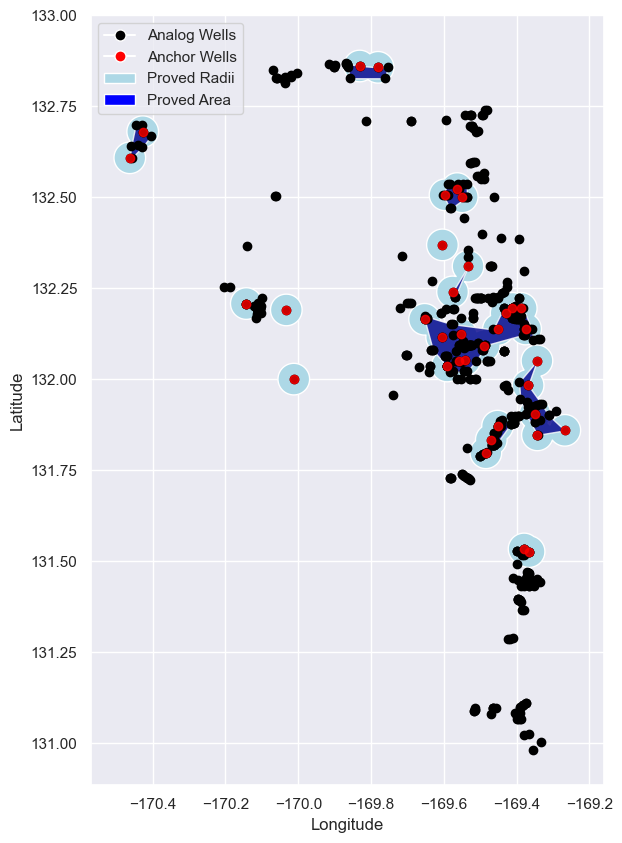

In [51]:
single_realization.plot_proved_areas()

## Proved Area: Multiple Realizations

Here, we once again instantiate a `ProvedArea` object, however, this time we set the `realizations` parameter equal to 500. Doing this allows us to generate a unique probabilistic solution to the proved area boundary using the aggregation of multiple realizations. Think Monte Carlo simulation. 

Currently, the program is not set-up to generate the realizations in parallel and will thus take a few minutes to complete depending on the processing power of your computer. 

Note, in the example given below, approximately 10% (50/500) realizations were not used as the selected anchor points were not representative of the analog well set distribution. 

In [8]:
multiple_realizations = ProvedArea(500, headers, forecast_parameters)

Generating realizations...
Realization Number: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 2

### Stack and aggregate realizations

With multiple realizations to play with, we can now use the `plot_aggregate_realization()` method to visualize the aggregated results. First, however, it's important to understand what this function is actually doing. 

Technically speaking, every realization generated is considerd statistically "proven" as defined by the SPEE Monograph 3 workflow. That being said, since the realizations vary highly with anchor well selection, some proven areas will be more optimistic and wide ranging, while others will be more conservative and smaller in domain. Therefore, in order to combat the variability in our outputs, we must perform a method of aggregation to ultimately yield some sort of reproducible answer. Although the proved area domain may vary largely from realization to realization, certain 'pieces' of the proved area may show up more often than others. This idea is essentially how the aggregation routine works. For all proved area realizations, imagine we took each ouput and stacked it vertically on top of one another. From there, we can count the number of overlapping 'pieces' between the various realization layers and make the assumption that pieces with higher overlaps can more confidently be considered part of the true proven area. In the charts shown below, you can see that the shape is broken up into various pieces with the lighter pieces representing sections of higher overlap and the darker pieces representing sections of lower overlap. 

In order to end up with a final 'proved' boundary or perimeter, we can choose a percentile by which we constrain our aggregated realization by the removal of pieces with low/no overlaps. Here, the smaller the percentile, the larger the number of required overlaps must be present for the piece to be included in the final output. Therefore, if you plotted the 99th percentile, you'd get a rather large final boundary whereas if you plotted the 10th percentile, you'd get a smaller boundary containing only the pieces that had a high amount of overlaps. I.e. the pieces for which we are most confident that they belong in the proved area of the resource play. 

![Overlap Diagram](Overlaps.png)

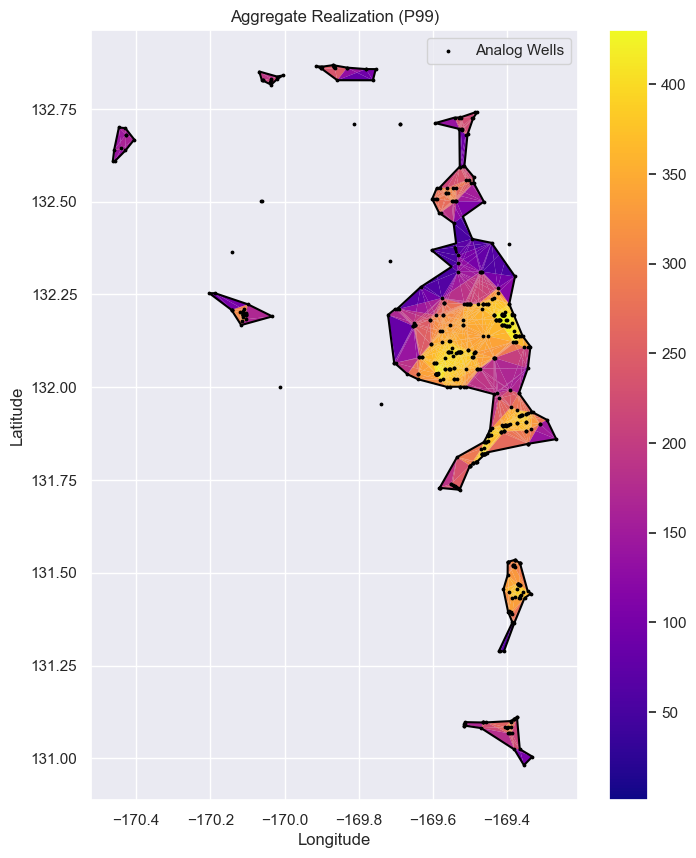

In [9]:
multiple_realizations.plot_aggregate_realization(0.99)

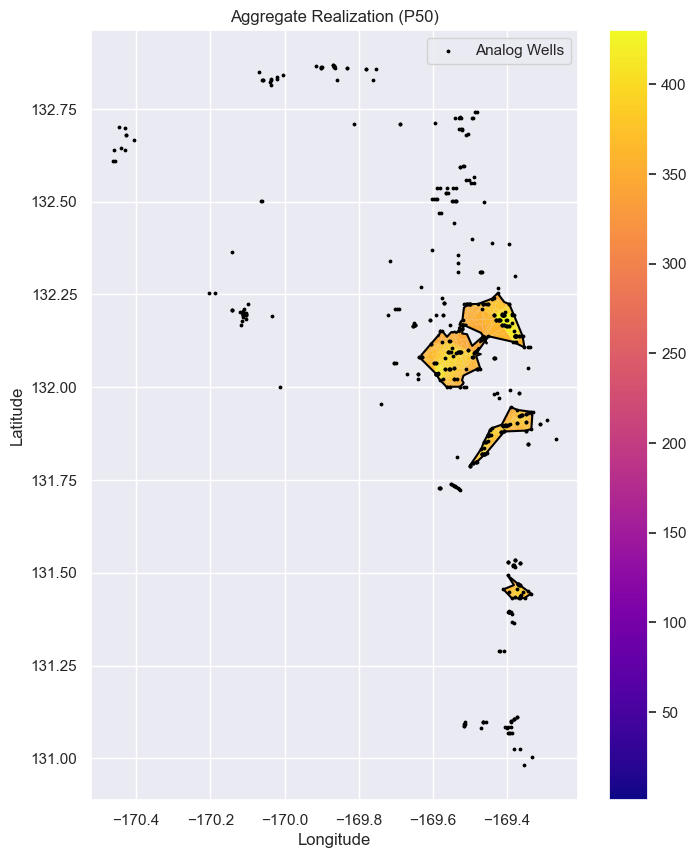

In [10]:
multiple_realizations.plot_aggregate_realization(0.5)

### Export results as a ShapeFile

Once you've decided which percentile you'd like to proceed with, you can export the boundary of the proved area as a ShapeFile that can be uploaded back into ComboCurve. 

The `export_shapefiles()` method will create and save a .zip file containing the requisite components of a working ShapeFile. From here, you can simply navigate to the Map Settings page of ComboCurve and upload it accordingly. 

In [ ]:
multiple_realizations.export_shapefiles(0.9)